# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [ ]:
pip install --upgrade pip

In [ ]:
!pip install --no-cache-dir transformers sentencepiece

In [ ]:
# !conda config --append channels conda-forge
# !conda install -y gsutil

In [ ]:
# !pip uninstall torch torchvision torchtext
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [3]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

# Соображения по методологии

# Проведение одного эксперимента
1. Подбирайте гиперпараметры! Это довольно важно. Гиперпараметры --- это размеры слоёв, например. Хотя бы в одном эксперименте это стоит сделать честно, в остальных экспериментах в принципе можно предполагать, что в предыдущем эксперименте оптимальные размеры модели уже найдены.
2. Часто вам придётся скачивать предобученные веса (вроде BERT или RoBERTa) и дообучать дополнительные веса. В таком случае стоит попробовать несколько разных подходов:
* обучать только новые (головные) слои 
* обучать совместно всю модель
* сначала обучить головные слои, потом дофайнтьюнить веса всей модели
3. Фиксируйте лучшие результаты на валидационной выборке, по валидационной же выборке останавливайте обучение
4. Графики, графики, графики
5. Делайте промежуточные выводы

# Общие соображения
1. Один эксперимент --- одно изменение! Вы не представляете, насколько это важно. Пример: для эксперимента с моделью 1 Петя для получения эмбеддингов скачал предобученные веса BERT, а для эксперимента с моделью 2 -- предобученные веса RoBERTa. Вторая модель оказалась лучше, и Петя подумал, что архитектура второй модели лучше. Но, оказывается, с весами RoBERTa модель 1 работала бы не менее хорошо. 
2. Всегда сравнивайте результаты эксперимента с результатами всех остальных экспериментов и делайте промежуточные выводы. ***Это самый важный пункт!***
3. Не забывайте протестировать модель на адекватность. Для этого нужно задавать ей реальные вопросы и смотреть на ответы. Вопросы не должны быть элементами обучающей выборки!


## Часть 1. Эксплоративный анализ (1 балл)
1. Посчитайте долю yes и no классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстриуйте, как эти эвристики повлияли на структуру корпуса. 

In [ ]:
!pip install fasttext

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchtext.data import get_tokenizer
import fasttext

from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import pickle
import io

PICKLE_PROTOCOL = 4


def get_file(filename):
    with open(filename, "rb") as f:
        result = pickle.load(f)
    return result


def save_file(object_name, adr, append=False):
    flag = 'ab' if append else 'wb'
    with open(adr, flag) as f:
        pickle.dump(object_name, f, PICKLE_PROTOCOL)
    return 'Done'


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [7]:
tqdm.pandas()

In [8]:
data_train = pd.read_json('train.jsonl', lines=True)
data_dev = pd.read_json('dev.jsonl', lines=True)

In [7]:
data_train.head()

,question,title,answer,passage
0,do iran and afghanistan speak the same language,Persian language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,Good Samaritan law,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,Windows Movie Maker,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,Powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online,False,As with other games in The Elder Scrolls serie...


In [ ]:
tokenizer = get_tokenizer("basic_english")

In [ ]:
print('Objects in train set:', data_train.shape[0])

val_cnt = data_train.answer.value_counts(normalize=True)
print(f'Answers share:\n\tYes: {val_cnt[True]:.1%}\n\tNo: {val_cnt[False]:.1%}')

quest_len = data_train['question'].apply(lambda x: len(tokenizer(x)))
print(f'Mean Question Length: {quest_len.mean():.1f} words')

passage_len = data_train['passage'].apply(lambda x: len(tokenizer(x)))
print(f'Mean Passage Length: {passage_len.mean():.1f} words\n')

Objects in train set: 9427
Answers share:
	Yes: 62.3%
	No: 37.7%
Mean Question Length: 8.9 words
Mean Passage Length: 108.9 words



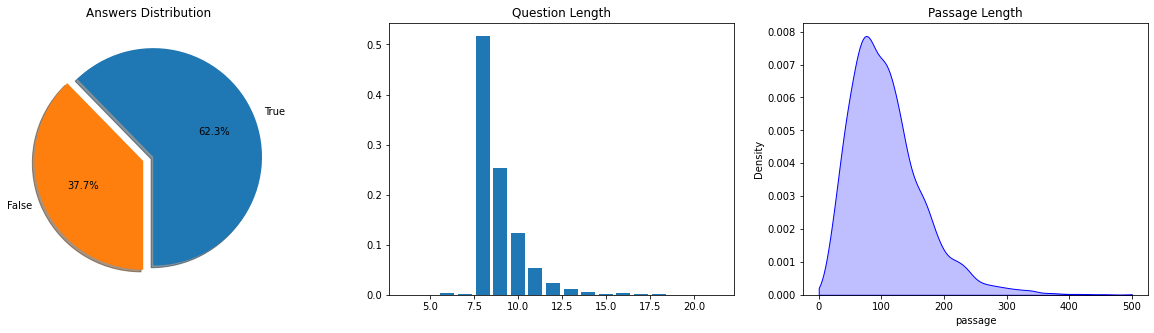

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 5));

ax[0].pie(val_cnt, labels=val_cnt.index, shadow=True, explode=[0.05, 0.05], startangle=-90, autopct='%.1f%%');
ax[0].set_title('Answers Distribution');

d_quest = quest_len.value_counts(sort=False, normalize=True)
ax[1].bar(d_quest.index, d_quest.values);
ax[1].set_title('Question Length');

ax[2].set_title('Passage Length');
sns.kdeplot(data=passage_len, clip=(0, 500), color='blue', fill=True, ax=ax[2]);

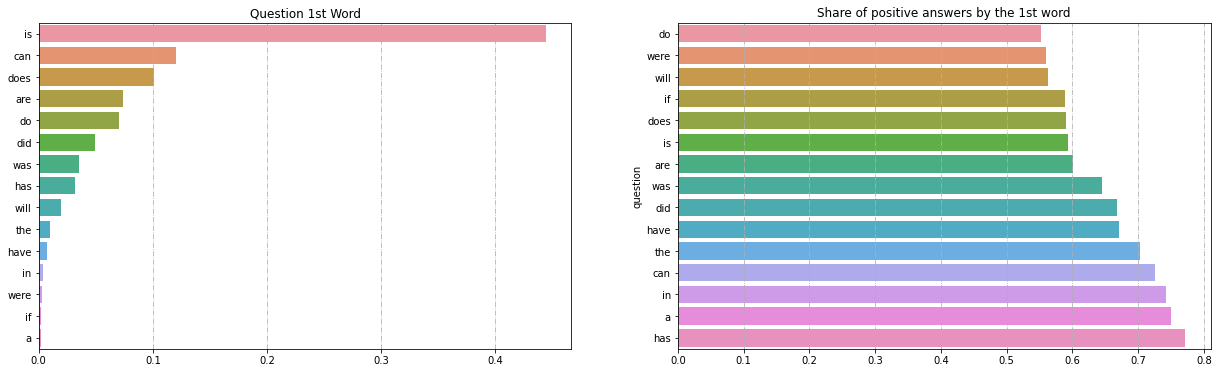

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 6));

first_words = data_train['question'].apply(lambda x: tokenizer(x)[0])
d_words = first_words.value_counts(sort=True, normalize=True)[:15]
sns.barplot(x=d_words.values, y=d_words.index, orient='h', ax=ax[0]);
ax[0].grid(axis='x', linestyle='-.')
ax[0].set_title('Question 1st Word');

major_first_words = d_words.index[:15]
d_mean_answ = data_train[first_words.isin(major_first_words)].groupby(first_words).answer.mean().sort_values()
sns.barplot(x=d_mean_answ.values, y=d_mean_answ.index, orient='h', ax=ax[1]);
ax[1].grid(axis='x', linestyle='-.')
ax[1].set_title('Share of positive answers by the 1st word');

Как показано в статье, вопросы в датасете составлены так, что для ответа на них необходимо использование различных эвристик:
- перефразирование

`Q: Is Tim Brown in the Hall of Fame?`<br>
`P: Brown has also played for the Tampa Bay Buccaneers. In 2015, he was
inducted into the Pro Football Hall of Fame.`<br>
`A: Yes. [“inducted into” directly implies he is in Hall of Fame.]`

- пример или контр-пример

`Q: Are there any nuclear power plants in Michigan?`<br>
`P: ... three nuclear power plants supply Michigan with about 30% of its electricity.`<br>
`A: Yes. [Since there must be at least three.]`

- заключение на основе фактов

`Q: Was designated survivor filmed in the White House?`<br>
`P: The series is... filmed in Toronto, Ontario.`<br>
`A: No. [The White House is not located in Toronto.]`

- неявный ответ в тексте

`Q: Is static pressure the same as atmospheric pressure?`<br>
`P: The aircraft designer’s objective is to ensure the pressure in the aircraft’s
static pressure system is as close as possible to the atmospheric pressure...`<br>
`A: No. [It would not make sense to bring them “as close as possible” if those
terms referred to the same thing.]`

- отсутствие упоминания

`Q: Did Bonnie Blair’s daughter make the Olympic team?`<br>
`P: Blair and Cruikshank have two children: a son, Grant, and daughter, Blair....
Blair Cruikshank competed at the 2018 United States Olympic speed skating
trials at the 500 meter distance.`<br>
`A: No. [The passage describes Blair Cruikshank’s daughter’s skating accomplishments,
so it would have mentioned it if she had qualified.]`

- иные эвристики

`Q: Is the sea snake the most venomous snake?`<br>
`P: ...the venom of the inland taipan, drop by drop, is the most toxic among all
snakes`<br>
`A: No. [If inland taipan is the most venomous snake, the sea snake must not
be.]`

## Часть 2. Baseline (1 балл)
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

In [ ]:
print('Objects in dev set:', data_dev.shape[0])

Objects in dev set: 3270


In [ ]:
scores = []
acc = accuracy_score(data_dev.answer, [True] * data_dev.shape[0])
scores.append({'Model': 'Majority class', 'Accuracy': acc})

print(f'"Always say YES" Baseline Accuracy: {acc :.4f}')

"Always say YES" Baseline Accuracy: 0.6217


In [ ]:
def prepare_for_fasttext(df, set_type='train'):
    sents = '__label__' + df.answer.astype(str) + ' ' + df.question + ' ' + df.passage
    fname = set_type + '_txt.txt'
    np.savetxt(fname, sents.values, fmt='%s')
    return fname

In [ ]:
fname_train = prepare_for_fasttext(data_train)
fname_dev = prepare_for_fasttext(data_dev, set_type='dev')

In [ ]:
model = fasttext.train_supervised(fname_train, epoch=15, wordNgrams=2, dim=200)

acc = model.test(fname_dev)[1]
scores.append({'Model': 'FastText', 'Accuracy': acc})

print(f'FastText Baseline Accuracy: {acc:.4f}')

FastText Baseline Accuracy: 0.6856


Как видим, fasttext не очень хорошо справляется с нашей задачей. Одна из причин заключается в том, что ответы на существенную часть вопросов не выводятся слишком просто из приведенных статей: как было показано выше, для успешного ответа на вопрос требуется использование различных видов эвристик.

## Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [11]:
from transformers import BertModel, BertTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [12]:
SEED = 118

In [20]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    return embeddings[0].cpu().numpy()


def get_bert_embs(model, txt_series):
    outp = []
    for txt in tqdm(txt_series):
        output = embed_bert_cls(txt, model, tokenizer)
        outp.append(output)
    return np.stack(outp, axis=0)


def search_param(features_train, target_train,
                 param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
                 ):
    estimator = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200, random_state=SEED)
    optimizer_lr = GridSearchCV(estimator, param_grid=param_grid,
                                cv=StratifiedKFold(4).split(features_train, target_train),                          
                                n_jobs=2, verbose=True)
    optimizer_lr.fit(features_train, target_train)
    return optimizer_lr.best_params_    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.cuda.empty_cache()

cuda


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [ ]:
quest_train_embs = get_bert_embs(model, data_train.question)
quest_dev_embs = get_bert_embs(model, data_dev.question)

pass_train_embs = get_bert_embs(model, data_train.passage)
pass_dev_embs = get_bert_embs(model, data_dev.passage)

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
train_features = np.concatenate((quest_train_embs, pass_train_embs), axis=1)
dev_features = np.concatenate((quest_dev_embs, pass_dev_embs), axis=1)

In [ ]:
param = search_param(train_features, data_train.answer)

param

Fitting 4 folds for each of 5 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


{'C': 0.01}

In [ ]:
estimator_final = LogisticRegression(**param, penalty='l2', solver='lbfgs', max_iter=1000, random_state=SEED)
estimator_final.fit(train_features, data_train.answer)

LogisticRegression(C=0.01, max_iter=1000, random_state=118)

In [ ]:
acc = accuracy_score(data_dev.answer, estimator_final.predict(dev_features))
scores.append({'Model': 'LogRegression / BERT embeddings', 'Accuracy': acc})

print(f'LogRegression on BERT embeddings Accuracy: {acc:.4f}')

LogRegression on BERT embeddings Accuracy: 0.6606


Попробуем использовать эмбеддинги модели RoBERTa:

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
quest_train_embs = get_bert_embs(model, data_train.question)
quest_dev_embs = get_bert_embs(model, data_dev.question)

pass_train_embs = get_bert_embs(model, data_train.passage)
pass_dev_embs = get_bert_embs(model, data_dev.passage)

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
train_features = np.concatenate((quest_train_embs, pass_train_embs), axis=1)
dev_features = np.concatenate((quest_dev_embs, pass_dev_embs), axis=1)

In [ ]:
estimator_final = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=1000, random_state=SEED)
estimator_final.fit(train_features, data_train.answer)

LogisticRegression(C=10, max_iter=1000, random_state=118)

In [ ]:
acc = accuracy_score(data_dev.answer, estimator_final.predict(dev_features))
scores.append({'Model': 'LogRegression / RoBERTa embeddings', 'Accuracy': acc})

print(f'LogRegression on RoBERTa embeddings Accuracy: {acc:.4f}')

LogRegression on RoBERTa embeddings Accuracy: 0.6719


Модель эмбеддингов RoBERTa позволила добиться более высокого показателя Accuracy:
0.6606 -> 0.6719

In [29]:
def scores_chart(x_lim=[0.6, 0.7]):
    sorted_scores = sorted(scores, key=lambda item: (item['Accuracy']), reverse=True)
    plt.figure(figsize=(7, 5));
    plt.xlim(x_lim)
    sns.set(font_scale=1.1)
    bar = sns.barplot(x=list(map(lambda x: x['Accuracy'], sorted_scores)),
                      y=list(map(lambda x: x['Model'], sorted_scores)),
                      orient='h');
    plt.grid(axis='x', linestyle='-.')                  
    bar.set(title='Model Accuracy');  

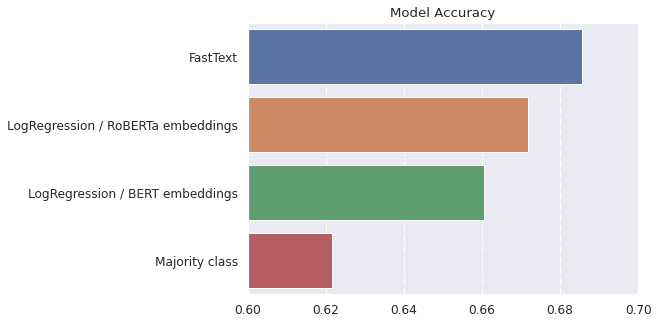

In [ ]:
scores_chart()

Расширим учебную выборку аугментированными данными. В качестве аугментации используем обратный перевод:<br> English -> German -> Russian -> English.

In [ ]:
!pip install pandarallel
!pip install googletrans==4.0.0-rc1

In [ ]:
from pandarallel import pandarallel
from googletrans import Translator

In [ ]:
pandarallel.initialize()
translator = Translator()

In [ ]:
def back_translate(data):
    try:
        translation = translator.translate(data, dest="de").text
        translation = translator.translate(translation, dest="ru").text
        return translator.translate(translation, dest="en").text
    except:
        return ''

In [ ]:
train_quest_back = data_train.question.parallel_apply(back_translate)
train_pass_back = data_train.passage.parallel_apply(back_translate)

Посмотрим на примеры исходных данных и их аугментации:

In [ ]:
for i in range(5):
    print(data_train.question.values[i], '\n\t', train_quest_back.values[i], '\n')

do iran and afghanistan speak the same language 
	 Do Iran and Afghanistan speak the same language? 

do good samaritan laws protect those who help at an accident 
	 A good Samaritan law protects those who help in an accident 

is windows movie maker part of windows essentials 
	 Is Windows Movie Maker part of Windows Essentials 

is confectionary sugar the same as powdered sugar 
	 Confectioners, as well as sugar 

is elder scrolls online the same as skyrim 
	 Elder Scrolls Online, as well as Skyrim 



In [ ]:
for i in range(3):
    print(data_train.passage.values[i], '\n\t', train_pass_back.values[i], '\n')

Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet. 
	 Persian (/ˈpɜːrʒən, -ʃən/), also known as its endonym Farsi (فارairs (fɒːɾˈsiː) (rumor)) is one of the Western languages in the Indo -Iranian branch of the Indo -European language.known as Dari since 1958) and Tajikistan (officially known as Tajiks from the Soviet era) and in some other regions that were historically considered and considered part of the great Uniran.Aramaic alphabet. 

Good Samaritan laws 

In [ ]:
# Для единообразия отрежем символ конца предложения (?.,) у аугментированных вариантов вопросов

quest_train_all = list(data_train.question.values) \
                    + [val[:-1] if (len(val) and val[-1] in '.,?') else val for val in train_quest_back.values]

pass_train_all = list(data_train.passage.values) + list(train_pass_back.values)

In [ ]:
assert len(quest_train_all) == len(pass_train_all) == data_train.shape[0] * 2

assert len(data_train.question) == len(train_quest_back.values) == len(data_train.passage) == len(train_pass_back.values) == data_train.shape[0]

In [ ]:
quest_train_all = pd.Series(quest_train_all)
pass_train_all = pd.Series(pass_train_all)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
quest_train_embs = get_bert_embs(model, quest_train_all)
quest_dev_embs = get_bert_embs(model, data_dev.question)

pass_train_embs = get_bert_embs(model, pass_train_all)
pass_dev_embs = get_bert_embs(model, data_dev.passage)

  0%|          | 0/18854 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

  0%|          | 0/18854 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
train_features = np.concatenate((quest_train_embs, pass_train_embs), axis=1)
dev_features = np.concatenate((quest_dev_embs, pass_dev_embs), axis=1)

In [ ]:
train_features.shape, dev_features.shape

((18854, 1536), (3270, 1536))

In [ ]:
estimator_final = LogisticRegression(C=0.02, penalty='l2', solver='lbfgs', max_iter=1000, random_state=SEED)
estimator_final.fit(train_features, list(data_train.answer.values) * 2)

LogisticRegression(C=0.02, max_iter=1000, random_state=118)

In [ ]:
accuracy_score(data_dev.answer, estimator_final.predict(dev_features))

0.6605504587155964

Добиться улучшения качества модели LogRegression / BERT embeddings за счет добавления аугментированных данных не удалось: Accuracy остается на том же уровне (0.6606)<br>
Попробуем улучшить качество модели LogRegression / RoBERTa embeddings:

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

In [ ]:
quest_train_embs = get_bert_embs(model, quest_train_all)
quest_dev_embs = get_bert_embs(model, data_dev.question)

pass_train_embs = get_bert_embs(model, pass_train_all)
pass_dev_embs = get_bert_embs(model, data_dev.passage)

  0%|          | 0/18854 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

  0%|          | 0/18854 [00:00<?, ?it/s]

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
train_features = np.concatenate((quest_train_embs, pass_train_embs), axis=1)
dev_features = np.concatenate((quest_dev_embs, pass_dev_embs), axis=1)

In [ ]:
estimator_final = LogisticRegression(C=1.8, penalty='l2', solver='lbfgs', max_iter=1000, random_state=SEED)
estimator_final.fit(train_features, list(data_train.answer.values) * 2)

LogisticRegression(C=1.8, max_iter=1000, random_state=118)

In [ ]:
accuracy_score(data_dev.answer, estimator_final.predict(dev_features))

0.6685015290519878

Добавление аугментации в случае с эмбеддингами RoBERTа также не помогло улучшить качество модели, метрика Accuracy даже упала: 0.6719 -> 0.6685

## Часть 4. Обучаем BERT на конкатенации вопроса и предложения (2 балла)

В этой части предлагается реализовать фреймворк, описанный в [видео по ссылке](https://www.youtube.com/watch?v=l8ZYCvgGu0o), адаптировав его под бинарный Question Answering. 

1. Опишите модель, которую вы будете реализовывать. Загрузите предобученный BERT, добавьте полносвязные "головные" слои. Дообучите модель: попробуйте разные способы обучения.

[bonus] Используйте модель [RoBERTa](https://arxiv.org/abs/1907.11692) вместо модели BERT. Посмотрите, что получилось.

В качестве inputs будем использовать токены вопроса и параграфа, разделенные между собой тегом [SEP]. Помимо этого, в token_type_ids будем передавать '0' для токенов, соотвествующих вопросу, и '1' для токенов параграфа.<br>
В качестве "головы" будем использовать два FC-слоя; на выходе модели получаем два логита для положительного и отрицательного ответа на вопросы.

In [11]:
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import time

In [12]:
from transformers import logging as transformers_logging
transformers_logging.set_verbosity_error()

In [13]:
SEED = 118
BATCH_SIZE = 8

In [8]:
data_val, data_test = train_test_split(data_dev, train_size=0.5, shuffle=True, stratify=data_dev.answer, random_state=SEED)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
class BoolQDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        questions = df.question.values
        passages = df.passage.values
        answers = df.answer.values

        self.labels = [int(a) for a in answers]

        self.input_ids, self.segment_ids, self.attention_mask = [], [], []

        for question, passage in tqdm(zip(questions, passages), total=len(questions)):
            tok = tokenizer(question, passage, max_length=max_len, padding='max_length', truncation=True)
            self.input_ids.append(tok['input_ids'])
            self.segment_ids.append(tok['token_type_ids'])
            self.attention_mask.append(tok['attention_mask'])
        self.input_ids = torch.tensor(self.input_ids)
        self.segment_ids = torch.tensor(self.segment_ids)
        self.attention_mask = torch.tensor(self.attention_mask)
        
    def __getitem__(self, idx):
        return {'inputs': self.input_ids[idx],
                'segment_ids': self.segment_ids[idx],
                'attention_mask': self.attention_mask[idx],
                'labels': self.labels[idx]}

    def __len__(self):
        return len(self.labels)

In [ ]:
train_data_set = BoolQDataset(data_train, tokenizer)
val_data_set = BoolQDataset(data_val, tokenizer)
test_data_set = BoolQDataset(data_test, tokenizer)

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data_set, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class BertBinaryQA(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        input_size = 768
        hidden_size = 64
        output_size = 2
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            self.relu,
            self.dropout,
            nn.Linear(hidden_size, output_size)            
        )
    
    def forward(self, inputs, segment_ids, attention_mask):
        outputs = self.bert(input_ids=inputs, token_type_ids=segment_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs[0][:, 0, :])
        return logits

In [12]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def plot_performance(epoch_history, train_loss, val_loss, acc):
    n = 0 if epoch_history is None else 1
    fig, ax = plt.subplots(nrows=1, ncols=2+n, figsize=(13+n*6, 6))
    clear_output(True)
    if epoch_history is not None:
        ax[0].plot(epoch_history)
        ax[0].plot(moving_average(epoch_history))
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train history')
    if train_loss is not None and len(train_loss) > 1:
        x_labels = range(1, len(train_loss) + 1)
        ax[n].plot(x_labels, train_loss, label='Train Loss')
        ax[n].plot(x_labels, val_loss, label='Valid Loss')
        ax[n].grid(axis='y', linestyle='-.')
        ax[n].set_xlabel('Epoch')
        ax[n].set_title('Loss')
        ax[n].legend()
    if acc is not None and len(acc) > 1:
        x_labels = range(1, len(acc) + 1)
        ax[n + 1].plot(x_labels, acc)
        ax[n + 1].grid(axis='y', linestyle='-.')
        ax[n + 1].set_xlabel('Epoch')  
        ax[n + 1].set_title('Valid Accuracy')
    plt.show()
    
    if train_loss is not None and len(train_loss) == 1:
        print(f'Val Loss: {train_history[0]:.3f}')
    if acc is not None and len(acc) == 1:
        print(f'Val Accuracy: {acc[0]:.3f}')
        
        
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs        

In [13]:
def train_bert(model, iterator, optimizer, criterion, scheduler=None, clip=None,
          train_history=None, valid_history=None, valid_accuracy=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        inputs = batch['inputs'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model(inputs, segment_ids=segment_ids, attention_mask=attention_mask)

        loss = criterion(output, labels) 
        loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        epoch_loss += loss.item()      
        history.append(loss.cpu().data.numpy())

        if (i + 1) % 30 == 0:
            plot_performance(history, train_history, valid_history, valid_accuracy)

    return epoch_loss / (i + 1), history


def evaluate_bert(model, iterator, criterion):
    targets, preds = [], []

    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for batch in tqdm(iterator):            
            targets.extend(batch['labels'])

            inputs = batch['inputs'].to(device)
            segment_ids = batch['segment_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(inputs, segment_ids=segment_ids, attention_mask=attention_mask)

            pred = torch.argmax(output, 1).cpu()
            preds.extend(pred)

            loss = criterion(output, labels)            
            epoch_loss += loss.item()
        
    return epoch_loss / sum(1 for _ in iterator), accuracy_score(targets, preds)

In [ ]:
N_EPOCHS = 4
LR = 2e-5
CLIP = None

torch.cuda.empty_cache()

bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
model = BertBinaryQA(bert_model).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
# total_scheduler_steps = sum(1 for _ in train_loader) * N_EPOCHS
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                            num_warmup_steps=0,
#                                            num_training_steps=total_scheduler_steps)
scheduler = None
criterion = nn.CrossEntropyLoss()

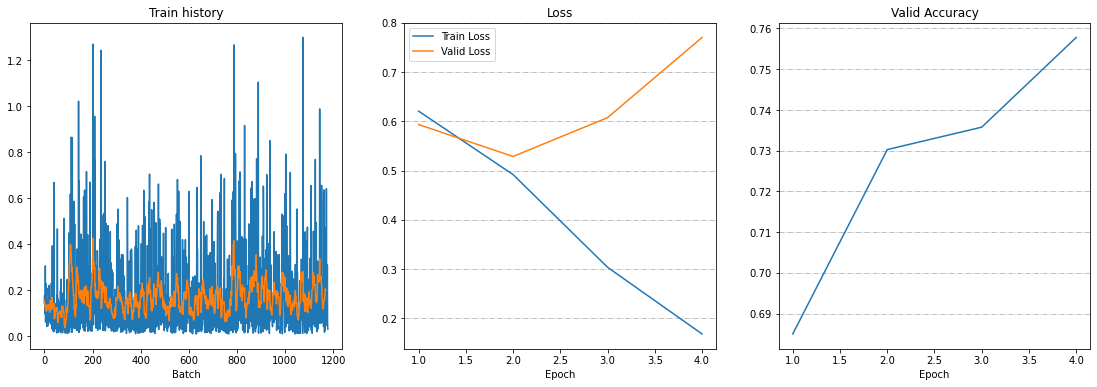

Epoch: 4 | Time: 4m 38s
	Train Loss: 0.168
	 Val Loss: 0.770	 Val Accuracy: 0.758


In [ ]:
train_history, valid_history, valid_accuracy = [], [], []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train_bert(model, train_loader, optimizer, criterion,
                                scheduler=scheduler, clip=CLIP, 
                                train_history=train_history, valid_history=valid_history,
                                valid_accuracy=valid_accuracy)
    valid_loss, valid_acc = evaluate_bert(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:      
        best_valid_loss = valid_loss
        save_file(model, 'model_best.pkl')        
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    valid_accuracy.append(valid_acc)
    
    plot_performance(history, train_history, valid_history, valid_accuracy)

    print(f'Epoch: {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f}\t Val Accuracy: {valid_acc:.3f}')

При обучении тестировались различные варианты:
- различный learning rate: 2e-5, 3e-5, 5e-5
- использование/неиспользование шедулера
- использование/неиспользование gradient clipping
- использование/неиспользование weight decay
- количество эпох 4-5

Качество модели оценивалось по результату на валидационной выборке. Наилучшее качество с точки зрения Val Accuracy достигалось без использования шедулера, клиппинга градиентов и регуляризации.<br>
Отметим, что хоть Val Loss начал падать уже на 3й эпохе обучения, метрика Accuracy продолжала расти, поэтому обучение модели было продолжено. В то же время, на 5й эпохе начиналось падение Accuracy, поэтому обучение проходило в течение 4 эпох.

In [ ]:
print(f'Test Accuracy: {evaluate_bert(model, test_loader, criterion)[1]:.4f}')

  0%|          | 0/205 [00:00<?, ?it/s]

Test Accuracy: 0.7462


In [ ]:
dev_data_set = BoolQDataset(data_dev, tokenizer)
dev_loader = DataLoader(dev_data_set, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
acc = evaluate_bert(model, dev_loader, criterion)[1]
scores.append({'Model': 'BERT / QA concatenation', 'Accuracy': acc})

print(f'BERT on QA concatenation Accuracy: {acc:.4f}')

  0%|          | 0/409 [00:00<?, ?it/s]

BERT on QA concatenation Accuracy: 0.7520


Удалось добиться значительного роста качества: Accuracy 0.7520 существенно превышает результат лучшей до этого момента модели (0.6856, FastText).

In [ ]:
save_file(model, 'model_bert_qa.pkl')

'Done'

Построим аналогичную модель на основе RoBERTa. Учтем, что RoBERTa не использует параметр token_type_ids:

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

In [15]:
class RobertaBoolQDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=512):
        questions = df.question.values
        passages = df.passage.values
        answers = df.answer.values

        self.labels = [int(a) for a in answers]

        self.input_ids, self.attention_mask = [], []

        for question, passage in tqdm(zip(questions, passages), total=len(questions)):
            tok = tokenizer(question, passage, max_length=max_len, padding='max_length', truncation=True)
            self.input_ids.append(tok['input_ids'])
            self.attention_mask.append(tok['attention_mask'])
        self.input_ids = torch.tensor(self.input_ids)
        self.attention_mask = torch.tensor(self.attention_mask)
        
    def __getitem__(self, idx):
        return {'inputs': self.input_ids[idx],
                'attention_mask': self.attention_mask[idx],
                'labels': self.labels[idx]}

    def __len__(self):
        return len(self.labels)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_data_set = RobertaBoolQDataset(data_train, tokenizer)
val_data_set = RobertaBoolQDataset(data_val, tokenizer)
test_data_set = RobertaBoolQDataset(data_test, tokenizer)

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

In [ ]:
BATCH_SIZE = 16

train_loader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data_set, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
class RobertaBinaryQA(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

        input_size = 768
        hidden_size = 64
        output_size = 2
        self.classifier = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            self.relu,
            self.dropout,
            nn.Linear(hidden_size, output_size)            
        )
    
    def forward(self, inputs, attention_mask):
        outputs = self.bert(input_ids=inputs, attention_mask=attention_mask)
        logits = self.classifier(outputs[0][:, 0, :])
        return logits

In [ ]:
def train_roberta(model, iterator, optimizer, criterion, scheduler=None, clip=None,
          train_history=None, valid_history=None, valid_accuracy=None):
    model.train()
    
    epoch_loss = 0
    history = []

    for i, batch in enumerate(iterator):
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model(inputs, attention_mask=attention_mask)

        loss = criterion(output, labels) 
        loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        epoch_loss += loss.item()      
        history.append(loss.cpu().data.numpy())

        if (i + 1) % 10 == 0:
            plot_performance(history, train_history, valid_history, valid_accuracy)

    return epoch_loss / (i + 1), history


def evaluate_roberta(model, iterator, criterion):
    targets, preds = [], []

    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
        for batch in tqdm(iterator):            
            targets.extend(batch['labels'])

            inputs = batch['inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            output = model(inputs, attention_mask=attention_mask)

            pred = torch.argmax(output, 1).cpu()
            preds.extend(pred)

            loss = criterion(output, labels)            
            epoch_loss += loss.item()
        
    return epoch_loss / sum(1 for _ in iterator), accuracy_score(targets, preds)

In [ ]:
N_EPOCHS = 4
LR = 2e-5
CLIP = None

torch.cuda.empty_cache()

roberta_model = RobertaModel.from_pretrained('roberta-base').to(device)
model = RobertaBinaryQA(roberta_model).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = None
criterion = nn.CrossEntropyLoss()

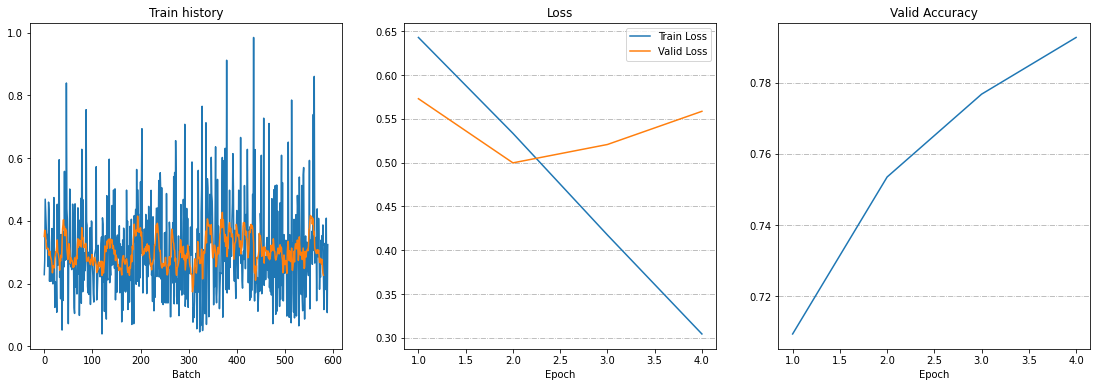

Epoch: 4 | Time: 15m 54s
	Train Loss: 0.304
	 Val Loss: 0.559	 Val Accuracy: 0.793


In [ ]:
train_history, valid_history, valid_accuracy = [], [], []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train_roberta(model, train_loader, optimizer, criterion,
                                scheduler=scheduler, clip=CLIP, 
                                train_history=train_history, valid_history=valid_history,
                                valid_accuracy=valid_accuracy)
    valid_loss, valid_acc = evaluate_roberta(model, val_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:      
        best_valid_loss = valid_loss
        save_file(model, 'model_best.pkl')        
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    valid_accuracy.append(valid_acc)
    
    plot_performance(history, train_history, valid_history, valid_accuracy)

    print(f'Epoch: {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f}\t Val Accuracy: {valid_acc:.3f}')

Как и в случае с BERT, наилучшее качество модели достигалось без использования шедулера, клиппинга градиентов и регуляризации, при обучении в течение 4 эпох. При этом Val Loss также начал падать с 3й эпохи обучения, а Val Accuracy продолжала расти еще 2 эпохи.

In [ ]:
print(f'Test Accuracy: {evaluate_roberta(model, test_loader, criterion)[1]:.4f}')

  0%|          | 0/103 [00:00<?, ?it/s]

Test Accuracy: 0.7804


In [ ]:
dev_data_set = RobertaBoolQDataset(data_dev, tokenizer)
dev_loader = DataLoader(dev_data_set, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/3270 [00:00<?, ?it/s]

In [ ]:
scores = get_file('scores.pkl')

In [ ]:
acc = evaluate_roberta(model, dev_loader, criterion)[1]
scores.append({'Model': 'RoBERTa / QA concatenation', 'Accuracy': acc})
print(f'RoBERTa on QA concatenation Accuracy: {acc:.4f}')

  0%|          | 0/205 [00:00<?, ?it/s]

RoBERTa on QA concatenation Accuracy: 0.7865


Использование RoBERTa позволило еще сильнее поднять качество нашей модели:

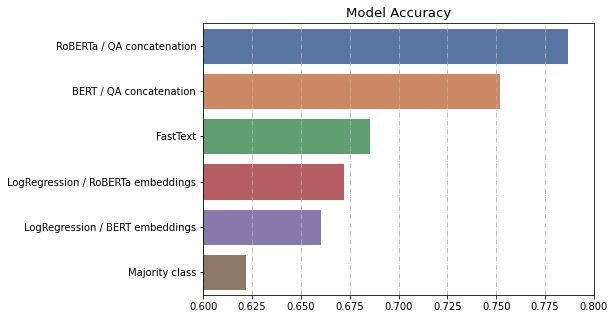

In [ ]:
scores_chart(x_lim=[0.6, 0.8])

In [ ]:
save_file(model, 'model_roberta_qa.pkl')

'Done'

Построем еще одну модель, на этот раз на основе DeBERTa. Т.к. в DeBERTa также используются token_type_ids, используем написанные ранее функции для модели BERT:

In [14]:
from transformers import AutoModel, AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [16]:
train_data_set = BoolQDataset(data_train, tokenizer)
val_data_set = BoolQDataset(data_val, tokenizer)
test_data_set = BoolQDataset(data_test, tokenizer)

  0%|          | 0/9427 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

  0%|          | 0/1635 [00:00<?, ?it/s]

In [17]:
BATCH_SIZE = 8

train_loader = DataLoader(train_data_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data_set, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
N_EPOCHS = 4
LR = 2e-5
CLIP = None

torch.cuda.empty_cache()

deberta_model = AutoModel.from_pretrained('microsoft/deberta-v3-base').to(device)
model = BertBinaryQA(deberta_model).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = None
criterion = nn.CrossEntropyLoss()

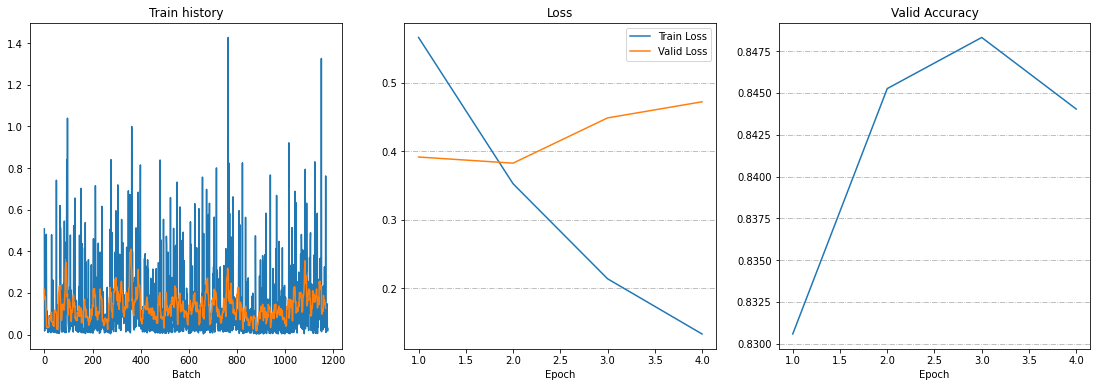

Epoch: 4 | Time: 23m 24s
	Train Loss: 0.133
	 Val Loss: 0.472	 Val Accuracy: 0.844


In [26]:
train_history, valid_history, valid_accuracy = [], [], []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, history = train_bert(model, train_loader, optimizer, criterion,
                                scheduler=scheduler, clip=CLIP, 
                                train_history=train_history, valid_history=valid_history,
                                valid_accuracy=valid_accuracy)
    valid_loss, valid_acc = evaluate_bert(model, val_loader, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    save_file(model, f'model_best_{epoch+1}.pkl')        
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    valid_accuracy.append(valid_acc)
    
    plot_performance(history, train_history, valid_history, valid_accuracy)

    print(f'Epoch: {epoch + 1} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val Loss: {valid_loss:.3f}\t Val Accuracy: {valid_acc:.3f}')

In [27]:
print(f'Test Accuracy: {evaluate_bert(model, test_loader, criterion)[1]:.4f}')

  0%|          | 0/205 [00:00<?, ?it/s]

Test Accuracy: 0.8220


In [22]:
dev_data_set = BoolQDataset(data_dev, tokenizer)
dev_loader = DataLoader(dev_data_set, batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/3270 [00:00<?, ?it/s]

In [28]:
acc = evaluate_bert(model, dev_loader, criterion)[1]
scores.append({'Model': 'DEBERTA / QA concatenation', 'Accuracy': acc})
print(f'DEBERTA on QA concatenation Accuracy: {acc:.4f}')

  0%|          | 0/409 [00:00<?, ?it/s]

DEBERTA on QA concatenation Accuracy: 0.8330


Как ожидалось, использование DeBERTa позволило существенно поднять Accuracy модели по сравнению с RoBERTa: 0.7865 -> 0.8330.

In [32]:
save_file(model, 'model_deberta_qa.pkl')

'Done'

## Часть 5. BiDAF-подобная архитектура (2 балла)

Архитектура BiDAF является специфической архитектурой для QA. Здесь вам предлагается её реализовать.

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT или RoBERTa эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

Реализовать архитектуру BiDAF для задачи ответа на бинарные вопросы можно было бы, взяв только один ее выход (например, соответствующий выходу Start на приведенной схеме) в качестве логитов для Yes / No:

In [ ]:
# Оригинальная реализация forward()
# https://github.com/galsang/BiDAF-pytorch/blob/master/model/model.py

def forward(self, batch):
    # 1. Character Embedding Layer
    c_char = char_emb_layer(batch.c_char)
    q_char = char_emb_layer(batch.q_char)
    # 2. Word Embedding Layer
    c_word = self.word_emb(batch.c_word[0])
    q_word = self.word_emb(batch.q_word[0])
    c_lens = batch.c_word[1]
    q_lens = batch.q_word[1]
    # Highway network
    c = highway_network(c_char, c_word)
    q = highway_network(q_char, q_word)
    # 3. Contextual Embedding Layer
    c = self.context_LSTM((c, c_lens))[0]
    q = self.context_LSTM((q, q_lens))[0]
    # 4. Attention Flow Layer
    g = att_flow_layer(c, q)
    
    # 5. Modeling Layer
    m = self.modeling_LSTM2((self.modeling_LSTM1((g, c_lens))[0], c_lens))[0]
    # 6. Output Layer
    p1, p2 = output_layer(g, m, c_lens)

    # (batch, c_len), (batch, c_len)
    return p1, p2

In [ ]:
# Модифицированная реализация forward() для ответа на бинарные вопросы
# (уровни 5 и 6)

def forward(self, batch):
    # 1. Character Embedding Layer
    c_char = char_emb_layer(batch.c_char)
    q_char = char_emb_layer(batch.q_char)
    # 2. Word Embedding Layer
    c_word = self.word_emb(batch.c_word[0])
    q_word = self.word_emb(batch.q_word[0])
    c_lens = batch.c_word[1]
    q_lens = batch.q_word[1]
    # Highway network
    c = highway_network(c_char, c_word)
    q = highway_network(q_char, q_word)
    # 3. Contextual Embedding Layer
    c = self.context_LSTM((c, c_lens))[0]
    q = self.context_LSTM((q, q_lens))[0]
    # 4. Attention Flow Layer
    g = att_flow_layer(c, q)

    # 5. Modeling Layer
    m = self.modeling_LSTM1((g, c_lens))[0]    
    # 6. Output Layer
    logits = output_layer_(g, m, c_lens)

    return logits

## Часть 6. Итоги (2 балла)
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

Визуализируем оценку качества всех разработанных моделей:

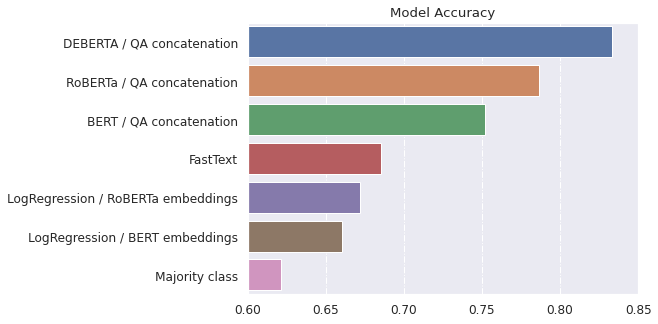

In [31]:
scores_chart(x_lim=[0.6, 0.85])

Использование конкатенированных эмбеддингов вопросов и параграфов моделей BERT и RoBERTa без дообучения в применении к нашей задаче не позволило построить модель с удовлетворительным качеством: **Accuracy на уровне 0.66..0.67**. Не помогло даже расширение набора данных за счет добавления в качестве аугментации обратного перевода текстов. Возможно, повысить качество помогло бы добавление в модель логистической регрессии новых признаков, например:
- расстояние между эмбеддингами вопроса и параграфа
- токен, соотвествующий первому слову в вопросе (как мы видели на шаге EDA, этот признак мог бы быть полезным).<br>

Обучение FastText также не дало высокого качества: **Accuracy 0.69**.<br>

При дообучении моделей-трансформеров удалось принципиально повысить долю верных ответов, Accuracy лучшей модели на основе DeBERTa достигла **0.8330**. Отметим, что данный результат все же далек от результатов SOTA-моделей на датасете BoolQ, Accuracy которых согласно [приводимым данным](https://super.gluebenchmark.com/leaderboard/) превосходит **0.90**.

Оценим, как справляется с нашей задачей предобученная на бинарных вопросах модель из библиотеки transformers - roberta-base-boolq:

In [17]:
from transformers import BertModel, BertTokenizer, RobertaTokenizer, RobertaModel, AutoModel, AutoTokenizer, AutoModelForSequenceClassification

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("shahrukhx01/roberta-base-boolq")
model.to(device) 

tokenizer = AutoTokenizer.from_pretrained("shahrukhx01/roberta-base-boolq")

In [21]:
def get_answer(question, passage, model, tokenizer, echo=True, sequence=False):
    max_len = 512
    tok = tokenizer(question, passage, max_length=max_len, padding='max_length', truncation=True)
    input_ids = torch.tensor(tok['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tok['attention_mask']).unsqueeze(0).to(device)
    segment_ids = tok.get('token_type_ids')
    segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device) if segment_ids is not None else segment_ids
    model.eval();
    with torch.no_grad():
        outp = model(input_ids, segment_ids=segment_ids, attention_mask=attention_mask) if segment_ids is not None \
                   else model(input_ids, attention_mask=attention_mask)
    if sequence:
        outp = outp[0]
    prob = torch.sigmoid(outp)
    answer = {'Yes': prob[0][1], 'No': prob[0][0]}
    if echo:
        if answer['Yes'] > answer['No']:
            print(f"TRUE: {answer['Yes']:.1%}\t false: {answer['No']:.1%}")
        else:
            print(f"FALSE: {answer['No']:.1%}\t true: {answer['Yes']:.1%}")

    return (answer['Yes'] > answer['No']).item()

In [29]:
ans_pred = []

for i in tqdm(range(data_dev.shape[0])):
    ans_pred.append(get_answer(data_dev.question[i], data_dev.passage[i], model, tokenizer, echo=False, sequence=True))

print(f'roberta-base-boolq Accuracy: {accuracy_score(data_dev.answer, ans_pred):.4f}')

roberta-base-boolq Accuracy: 0.8012


Как видим, данная модель справляется с задачей лучше, чем обученная выше модель на основе RoBERTa (Accuracy 0.7865), но ее качество все же сильно ниже по сравнению с лучшей из обученных нами моделей (0.8330).

Посмотрим, как три наши лучшие модели (BERT, RoBERTa, DeBERTa) и модель из библиотеки справляются с ответами на задаваемые вопросы:

In [22]:
roberta_base_boolq_tokenizer = tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
deberta_tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [27]:
roberta_base_boolq = model
bert_qa = CPU_Unpickler(open('model_bert_qa.pkl', 'rb')).load().to(device)
roberta_qa = CPU_Unpickler(open('model_roberta_qa.pkl', 'rb')).load().to(device)
deberta_qa = CPU_Unpickler(open('model_deberta_qa.pkl', 'rb')).load().to(device)

In [30]:
SEED = 118
Q_COUNT = 10

sample_objs = data_dev.sample(Q_COUNT, random_state=SEED)

qa_test = []

for i in sample_objs.index:
    sample_quest = sample_objs.question[i]
    sample_pass = sample_objs.passage[i]
    sample_ans = sample_objs.answer[i]

    print('Question:\t\t', sample_quest)
    print('Ground truth:\t\t', sample_ans)
    print('BERT:   ', end='\t\t')
    ans_bert = get_answer(sample_quest, sample_pass, bert_qa, bert_tokenizer)
    print('RoBERTa:', end='\t\t')
    ans_roberta = get_answer(sample_quest, sample_pass, roberta_qa, roberta_tokenizer)
    print('DeBERTa:', end='\t\t')
    ans_deberta = get_answer(sample_quest, sample_pass, deberta_qa, deberta_tokenizer)
    print('RoBERTa/transformers:', end='\t')
    ans_transf = get_answer(sample_quest, sample_pass, roberta_base_boolq, roberta_base_boolq_tokenizer, sequence=True)
    print('\n')

    qa_test.append({'Question': sample_quest,
                    'BERT': ans_bert == sample_ans,
                    'RoBERTa': ans_roberta == sample_ans,
                    'DeBERTa': ans_deberta == sample_ans,
                    'Transformers': ans_transf == sample_ans 
                    })

Question:		 is puerto rico subject to us federal law
Ground truth:		 True
BERT:   		TRUE: 85.1%	 false: 8.1%
RoBERTa:		TRUE: 89.6%	 false: 11.8%
DeBERTa:		TRUE: 94.6%	 false: 5.6%
RoBERTa/transformers:	TRUE: 93.5%	 false: 7.9%


Question:		 do you get overseas service bars for korea
Ground truth:		 True
BERT:   		TRUE: 70.2%	 false: 33.9%
RoBERTa:		TRUE: 84.4%	 false: 16.5%
DeBERTa:		TRUE: 86.7%	 false: 14.1%
RoBERTa/transformers:	TRUE: 89.0%	 false: 10.7%


Question:		 can you use the euro in the czech republic
Ground truth:		 False
BERT:   		FALSE: 89.2%	 true: 27.5%
RoBERTa:		TRUE: 79.0%	 false: 21.7%
DeBERTa:		FALSE: 74.8%	 true: 38.9%
RoBERTa/transformers:	TRUE: 91.8%	 false: 8.3%


Question:		 is there a difference between a confidentiality agreement and a non disclosure agreement
Ground truth:		 False
BERT:   		FALSE: 87.7%	 true: 28.0%
RoBERTa:		TRUE: 52.0%	 false: 47.1%
DeBERTa:		FALSE: 94.6%	 true: 13.0%
RoBERTa/transformers:	FALSE: 58.2%	 true: 34.9%


Question:		 is there a

Как видим, качество ответов моделей действительно в большей части случаев выглядит вполне адекватным.<br>
Визуализируем верные и неверные ответы моделей:

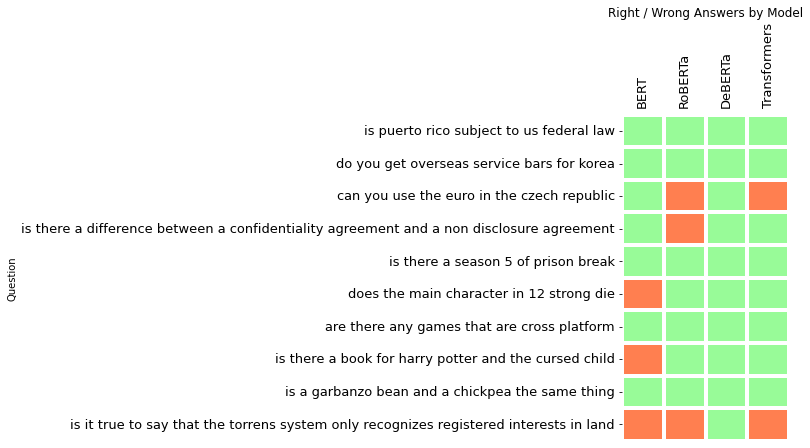

In [34]:
plt.figure(figsize=(3, 6))
sns.heatmap(pd.DataFrame(qa_test).set_index('Question'), cmap=['coral', 'palegreen'], linewidths=3, cbar=False);
plt.tick_params(axis='both', which='major', labelsize=13, labelbottom=False, bottom=False, top=False, labeltop=True)
plt.xticks(rotation=90);
plt.title('Right / Wrong Answers by Model');

Отметим, что в нашем мини-тесте у моделей BERT и RoBERTa оказалось по 3 неверных ответа из 10, модель из библиотеки transformers ошиблась дважды, в то время как DeBERTa продемонстрировала 100% качество!

Протестируем качество ответов нашей лучшей модели еще на нескольких новых вопросах:

In [91]:
get_answer('is pardus an animal', 'Pardus is a cat', deberta_qa, deberta_tokenizer)

TRUE: 94.0%	 false: 5.8%


True

In [179]:
get_answer('did i read less than 5 books this year', 'This summer I read 10 books.', deberta_qa, deberta_tokenizer)

FALSE: 94.7%	 true: 11.5%


False

In [191]:
passage = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower."
question = "is eiffel tower located in nantes"
get_answer(question, passage, deberta_qa, deberta_tokenizer)

FALSE: 89.5%	 true: 18.9%


False

In [178]:
question = "is eiffel tower made from metal"
get_answer(question, passage, deberta_qa, deberta_tokenizer)

TRUE: 92.3%	 false: 7.6%


True

Как ожидалось, модель без труда справилась с ответами на наши вопросы.